<a href="https://colab.research.google.com/github/sobhanshukueian/Simple-classification-using-deep-learning-on-MNIST/blob/main/simple__MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple classification using deep learning on MNIST

One way to classify images is using simple deep models, in this sample i used a model with three linear layers and relu activation in end of the architecture. In training process used crossEntropy loss function and Adam optimizer to update the weights. U can check the code and outputs.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib


#Declare transform to convert raw data to tensor
transforms = transforms.Compose([
								transforms.ToTensor()
])

# Loading Data and splitting it into train and validation data
train = datasets.MNIST('', train = True, transform = transforms, download = True)
train, valid = random_split(train,[50000,10000])

# Create Dataloader of the above tensor with batch size = 32
trainloader = DataLoader(train, batch_size=32)
validloader = DataLoader(valid, batch_size=32)

# Building Our Mode
class Network(nn.Module):
	# Declaring the Architecture
	def __init__(self):
		super(Network,self).__init__()
		self.fc1 = nn.Linear(28*28, 256)
		self.fc2 = nn.Linear(256, 128)
		self.fc3 = nn.Linear(128, 10)

	# Forward Pass
	def forward(self, x):
		x = x.view(x.shape[0],-1) # Flatten the images
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		return x


c:\Users\IT CITY\anaconda3\envs\torch-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device, epochs, batch_size, save_dir="/content/runs", train_loader=trainloader, valid_loader=validloader, weights=None):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = "SSL"
        self.weights=weights


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        
        # get model 
        self.model = self.get_model()

        # Get optimizer
        self.optimizer = self.get_optimizer()

        # Optimizer schedular and EMA
        self.scheduler, self.lf = self.get_lr_scheduler()
        self.ema = ModelEMA(self.model) if self.use_ema else None
    
# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = Network().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        print('Model: {}'.format(model))
        return model

    def get_optimizer(self, optimizer="Adam", lr0=0.01, momentum=0.937):
        weight_decay=0.0005
        accumulate = max(1, round(64 / self.batch_size))  # accumulate loss before optimizing
        weight_decay *= self.batch_size * accumulate / 64   # scale weight_decay

        g_bnw, g_w, g_b = [], [], []
        for v in self.model.modules():
            if hasattr(v, 'bias') and isinstance(v.bias, nn.Parameter):
                g_b.append(v.bias)
            if isinstance(v, nn.BatchNorm2d):
                g_bnw.append(v.weight)
            elif hasattr(v, 'weight') and isinstance(v.weight, nn.Parameter):
                g_w.append(v.weight)
        
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(g_bnw if len(g_bnw) > 0 else self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(g_bnw if len(g_bnw) > 0 else self.model.parameters(), lr=lr0, betas=(momentum, 0.999))

        if len(g_bnw) > 0:
            optim.add_param_group({'params': g_w, 'weight_decay': weight_decay})
            optim.add_param_group({'params': g_b})
        print(f"{'optimizer:'} {type(optim).__name__} with parameter groups "
                    f"{len(g_bnw)} weight (no decay), {len(g_w)} weight, {len(g_b)} bias")
        del g_bnw, g_w, g_b 
        return optim

    # Learning rate schedular
    def get_lr_scheduler(self, schedular="Cos", lrf=0.01):
        if schedular == 'Cos':
            lf = lambda x: ((1 - math.cos(x * math.pi / self.epochs)) / 2) * (lrf - 1) + 1
        else:
            print('unknown lr scheduler, use Cosine defaulted')
        scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lf)
        return scheduler, lf

    # Loss Function Definition
    def compute_loss(self, outputs, labels):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        return loss
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images = batch_data[0].to(device, non_blocking=True).float() / 255
        targets = batch_data[1].to(device)
        return images, targets

    # Each Train Step
    def train_step(self):
        images, targets = self.prepro_data(self.batch_data, self.device)
        # forward
        with amp.autocast(enabled=self.device != 'cpu'):
            preds = self.model(images)
            loss = self.compute_loss(preds, targets)

        # backward
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        if self.ema:
            self.ema.update(self.model)
        self.scheduler.step()
        
        return loss

    # Each Validation Step
    def val_step(self):
        self.model.eval()
        images, targets = self.prepro_data(self.val_batch_data, self.device)
        # forward
        preds = self.model(images)
        loss = self.compute_loss(preds, targets)
        return loss

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scheduler.last_epoch = - 1
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.model.train()
                    self.pbar = enumerate(self.train_loader)
                    self.pbar = tqdm(self.pbar, total=self.max_stepnum)

                    for self.step, self.batch_data in self.pbar:
                        train_loss = self.train_step()
                        self.pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Loss: {train_loss}  ")

                    # Validation Loop
                    self.vbar = enumerate(self.valid_loader)
                    self.vbar = tqdm(self.vbar, total=len(self.valid_loader))
                    for self.step, self.val_batch_data in self.vbar:
                        self.val_loss = self.val_step()
                        self.vbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tValidation Loss Loss: {self.val_loss}  ")
                    
                    if self.val_loss < self.best_loss:
                        self.best_loss=self.val_loss
                
                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.eval_and_save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    # -------------------------------------------------------Evaluation of Model-------------------------------------------
    def eval_and_save(self):
        # save model
        n = 1
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        while osp.exists(save_ckpt_dir):
            save_ckpt_dir = osp.join(self.save_dir, "weights_{}".format(n))
            n+=1
        os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name))
            shutil.copyfile(filename, best_filename)

Trainer(batch_size=32, device=0, epochs=20).train()


Model: Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
optimizer: Adam with parameter groups 0 weight (no decay), 3 weight, 3 bias
Start Training Process 
Time: Wed Sep 28 19:48:55 2022


Epoch: 0/20	Train Loss: 0.280242919921875  : 100%|██████████| 1563/1563 [00:13<00:00, 115.80it/s]  
Epoch: 0/20	Validation Loss Loss: 0.27501821517944336  : 100%|██████████| 313/313 [00:01<00:00, 207.37it/s]
Epoch: 1/20	Train Loss: 0.158849835395813  : 100%|██████████| 1563/1563 [00:10<00:00, 150.32it/s]   
Epoch: 1/20	Validation Loss Loss: 0.22660882771015167  : 100%|██████████| 313/313 [00:01<00:00, 199.96it/s]
Epoch: 2/20	Train Loss: 0.1555531919002533  : 100%|██████████| 1563/1563 [00:10<00:00, 147.11it/s]  
Epoch: 2/20	Validation Loss Loss: 0.24516735970973969  : 100%|██████████| 313/313 [00:01<00:00, 194.31it/s] 
Epoch: 3/20	Train Loss: 0.1326742172241211  : 100%|██████████| 1563/1563 [00:10<00:00, 148.96it/s]  
Epoch: 3/20	Validation Loss Loss: 0.26187664270401  : 100%|██████████| 313/313 [00:01<00:00, 221.58it/s]    
Epoch: 4/20	Train Loss: 0.07971986383199692  : 100%|██████████| 1563/1563 [00:10<00:00, 148.65it/s]  
Epoch: 4/20	Validation Loss Loss: 0.25900334119796753  : 100%


Training completed in Wed Sep 28 19:53:05 2022 
Its Done in: 0.070 hours.


In [ ]:
import matplotlib.pyplot as plt
iterr = iter(validloader)
def predict(weights, image):
    model = Network()
    # finetune if pretrained model is set
    print(f'Loading state_dict from {weights} for fine-tuning...')
    model.load_state_dict(torch.load(weights))
    pred = model(image)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    print("Prediction:  ", np.argmax(pred.cpu().detach()))

Loading state_dict from weis.pt for fine-tuning...


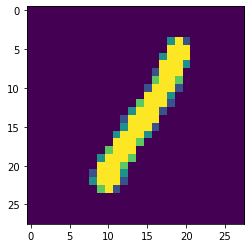

Prediction:   tensor(1)
Label:  tensor(1)
Loading state_dict from weis.pt for fine-tuning...


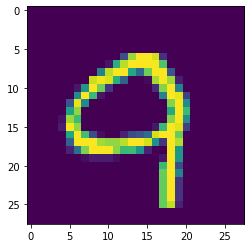

Prediction:   tensor(9)
Label:  tensor(9)
Loading state_dict from weis.pt for fine-tuning...


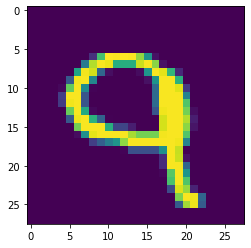

Prediction:   tensor(9)
Label:  tensor(9)
Loading state_dict from weis.pt for fine-tuning...


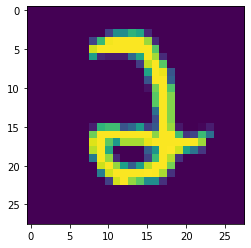

Prediction:   tensor(2)
Label:  tensor(2)
Loading state_dict from weis.pt for fine-tuning...


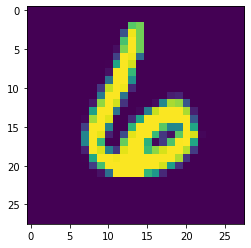

Prediction:   tensor(6)
Label:  tensor(6)


In [ ]:
for i in range(5):
    vis_batch = next(iterr)
    image = vis_batch[0][0]
    predict("weis.pt", image)
    print("Label: ", vis_batch[1][0])

